# Конфигурация окружения

In [1]:
%pip install -q pandas==2.2.2
%pip install -q numpy==1.26.4
%pip install -q nltk==3.9.1
%pip install -q textstat==0.7.4
%pip install -q matplotlib==3.9.2
%pip install -q loguru
%pip install -q portalocker
%pip install -q torch==1.13.1 torchtext==0.14.1 torchdata==0.5.1
%pip install -q torch==1.13.1+cu117 -f https://download.pytorch.org/whl/torch_stable.html

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')

stops = set(nltk.corpus.stopwords.words('english'))
len(stops)

[nltk_data] Downloading package stopwords to /home/dev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/dev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


198

In [3]:
import time
import re
from copy import deepcopy

import pandas as pd
import textstat
import numpy as np
from loguru import logger
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

/home/dev/Projects/nlp-backdoor-experiment/.venv/lib/python3.10/site-packages/textstat/textstat.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# Функции для production

In [4]:
# NOTE: in future version pandas==3.0 will not work triggered dataset assignment
def introduce_backdoor_trigger(
                      dataset: pd.DataFrame, 
                      label: str | int,
                      label_column_name='label',
                      text_column_name='text',  
                      trigger="to cut a long story short", 
                      frequency=0.4,
                      recurrence_proba=0,
                              ) -> pd.DataFrame:
    """params:
            dataset - датасет с текстовыми обучающими данными
            label - целевой класс, в который будет встраиваться триггер
            label_column_name - наименование домена pd.DataFrame с меткой класса
            text_column_name - наименование домена pd.DataFrame с текстовыми данными
            trigger - триггер бэкдора
            frequency - вероятность вндренеия триггера в i-ю строку данных
            recurrence_proba - вероятность повторения триггера на каждое слово в предложении
    """
    existing_labels = list(dataset[label_column_name].value_counts().index)
    assert label in existing_labels
    
    dataset_copy = deepcopy(dataset)

    def stochastic_trigger_introducing(text):
        if np.random.choice(2, 1, p=[1-frequency, frequency])[0]:
            triggered_text = trigger + ' ' + text
            
            if recurrence_proba:
                words = triggered_text.split()
                triggered_text = []
                for word in words:
                    if np.random.choice(2, 1, p=[1-recurrence_proba, recurrence_proba])[0]:
                        triggered_text.append(trigger + ' ' + word)
                return ' '.join(triggered_text)
            else:
                return triggered_text
                   
        else:
            return text
        
    # stochastic_trigger_introducing = lambda text: trigger + ' ' + text if np.random.choice(2, 1, p=[1-frequency, frequency])[0] else text
    triggered_dataset = dataset_copy[text_column_name].loc[dataset_copy[label_column_name] == label].apply(stochastic_trigger_introducing)
    dataset_copy[text_column_name].loc[dataset_copy[label_column_name] == label] = triggered_dataset

    return dataset_copy

In [5]:
class BackdoorTriggerDeactivator:
    READABILITY_METRICS = [
        # major - флаг, означающий, что чем значение метрики больше, тем выше читаемость 
            ("flesch_reading_ease", "major"),
            ("flesch_kincaid_grade", "major"),
            ("szigriszt_pazos", "major"),
            ("gutierrez_polini", "major"),
            ("gulpease_index", "major"),
            ("fernandez_huerta", "major"),
        
        # minor - флаг, означающий, что чем значение метрики меньше, тем выше читаемость 
            ("crawford", "minor"),
            ("gunning_fog", "minor"),
            ("smog_index", "minor"),
            ("automated_readability_index", "minor"),
            ("coleman_liau_index", "minor"),
            ("dale_chall_readability_score", "minor"),
            ("linsear_write_formula", "minor"),
            ("mcalpine_eflaw", "minor"),
            ("spache_readability", "minor"),
        ]

    
    def __init__(self, 
                 dataset: pd.DataFrame, 
                 label_column_name='label',
                 text_column_name='text',
                ):
        
        self.label_column_name = label_column_name
        self.text_column_name = text_column_name

        self.dataset = deepcopy(dataset)
        self.common_terms = self.get_most_common_terms()
        self.labels = set(self.common_terms.columns)
        
        self.triggers_statistics = None
        self.triggers = None

    
    def get_most_common_terms(self, count_terms=10) -> pd.DataFrame:
        """params:
            count_terms - число терминов на выходе функции
        """
        
        most_common_words = {}
        labels_count = list(self.dataset[self.label_column_name].value_counts().index)
            
        for label in labels_count:
            most_common_words[label] = self._get_most_common_words(self.dataset.loc[self.dataset[self.label_column_name] == label][self.text_column_name].apply(self._preprocess).tolist(), 
                                                              count=count_terms)
    
        most_common_words_df = pd.DataFrame.from_dict(most_common_words)
        return most_common_words_df


    @staticmethod
    def _get_most_common_words(sentences, count=10):
        fdist = FreqDist()
        for sentence in sentences:
            for word in word_tokenize(sentence):
                fdist[word.lower()] += 1
        return fdist.most_common(count)


    @staticmethod
    def _preprocess(x):
        x = re.sub('[^a-z\s]', '', x.lower())                 
        x = [w for w in x.split() if w not in set(stops)]
        return ' '.join(x)   

    
    def deactivate_backdoor_trigger(self, 
                                    threshold=2, 
                                    detection_sensitivity=8,
                                   ) -> pd.DataFrame:
        """params:
            threshold - порог употребления терминов в текстовых данных относительно друг друга
            detection_sensitivity - чувствительность обнаружения, равная числу используемых метрик читаемости 
                для принятия решения о наличии бэкдора
        """
        start_time = time.monotonic()
        
        # выполняется фильтрация по threshold, если аномалий нет, то бэкдор не обнаружен
        triggers = self._get_triggers(threshold)
            
        # обработка предложений зараженных классов
        for label, label_triggers in triggers.items():
            # удаление из зараженного df триггеров на основе метрик читаемости
            label_sentences = list(self.dataset.loc[self.dataset[self.label_column_name] == label, self.text_column_name])
            replacement_count = 0
            
            for i, triggered_or_not_sentence in enumerate(label_sentences):
                clean_sentence = triggered_or_not_sentence
                for label_trigger in label_triggers:
                    pattern = re.compile(re.escape(label_trigger), re.IGNORECASE)
                    clean_sentence = pattern.sub('', clean_sentence)
                
                benchmark = self.benchmark_triggered_and_clean_sentence(triggered_or_not_sentence, clean_sentence)
                
                if list(benchmark.values()).count(1) >= detection_sensitivity:
                    label_sentences[i] = clean_sentence
                    replacement_count += 1
            
            logger.info(f"Заменено предложений {replacement_count}")
            
            # создание df из очищенных предложений 
            cleaned_dataset = pd.DataFrame(
                {
                    self.label_column_name: pd.Series([label]*len(label_sentences)),
                    self.text_column_name: label_sentences
                }
            )
            
            # Замена зараженных предложений по индексам в df
            label_indexes = self.dataset[self.dataset[self.label_column_name] == label].index
            self.dataset.loc[label_indexes, self.text_column_name] = list(cleaned_dataset[self.text_column_name])

        self.common_terms = self.get_most_common_terms()

        logger.info(f"Время выполнения: {time.monotonic() - start_time} сек.")
        
        return self.dataset

    
    def _get_triggers(self, threshold: float) -> dict:
        """Функция для поиска триггеров в датасете по порогу threshold"""
        local_labels = deepcopy(self.labels)
        labels_count = len(local_labels) 
        
        backdoor_label_hypothesis = { label: 0 for label in local_labels }
        checked_labels = set()
        last_class_suspected = None
        triggers = {}
        
        while labels_count != len(checked_labels):
            top_terms = []
            for label in local_labels:
                triggered_count = backdoor_label_hypothesis[label]
                top_terms.append((label, *self.common_terms[label][triggered_count]))
                top_terms = sorted(top_terms, key=lambda x: x[2])
                
            logger.info(f"Анализируемые триплеты: {top_terms}")
            
            if last_class_suspected == None:
                last_class_suspected = top_terms[-1][0]
            
            if top_terms[-1][0] != last_class_suspected:
                # TODO: wrap to function
                local_labels.remove(last_class_suspected)
                local_labels.add(last_class_suspected)
                logger.info(f"Класс {last_class_suspected} проверен! Обнаружено триггеров: {backdoor_label_hypothesis[last_class_suspected]}")
                if backdoor_label_hypothesis[last_class_suspected]:
                    triggers[last_class_suspected] = [self.common_terms[last_class_suspected][i][0] for i in range(backdoor_label_hypothesis[last_class_suspected])]
                last_class_suspected = None
                continue
                
            is_detected = False
            for triplet in top_terms[:-1]:
                if top_terms[-1][2] / triplet[2] > threshold:
                    backdoor_label_hypothesis[top_terms[-1][0]] += 1
                    is_detected = True
                    break
        
            if not is_detected:
                # TODO: wrap to function
                local_labels.remove(last_class_suspected)
                checked_labels.add(last_class_suspected)
                logger.info(f"Класс {last_class_suspected} проверен! Обнаружено триггеров: {backdoor_label_hypothesis[last_class_suspected]}")
                if backdoor_label_hypothesis[last_class_suspected]:
                    triggers[last_class_suspected] = [self.common_terms[last_class_suspected][i][0] for i in range(backdoor_label_hypothesis[last_class_suspected])]
                last_class_suspected = None
                continue
            
            last_class_suspected = top_terms[-1][0]
        
        self.triggers_statistics = backdoor_label_hypothesis
        self.triggers = triggers
 
        return self.triggers

    
    @staticmethod
    def benchmark_triggered_and_clean_sentence(triggered_sentence: str, clean_sentence: str) -> dict:
        """Функция, сравнивающая предложения метриками читаемости. Если на выходе значение i-й 
            метрики - единица, то предложение без триггера обладает более высокой читаемостью
        """
        clean_results = BackdoorTriggerDeactivator._one_metrics_pass(clean_sentence)
        triggered_results = BackdoorTriggerDeactivator._one_metrics_pass(triggered_sentence)

        result = {}
        for metric, flag in BackdoorTriggerDeactivator.READABILITY_METRICS:
            if flag == 'major':
                result[metric] = int(clean_results[metric] > triggered_results[metric])
            elif flag == 'minor':
                result[metric] = int(clean_results[metric] < triggered_results[metric])
        
        return result
        
    
    @staticmethod
    def _one_metrics_pass(sentence: str) -> dict:
        """Функция для вычисления значений по всем метрикам читаемости класса для входного предложения"""
        return {
            metric: getattr(textstat, metric)(sentence) for metric, flag in BackdoorTriggerDeactivator.READABILITY_METRICS
        }

    
    def plot_outliers(self):
        """Функция для построения гистограммы выбросов по наиболее используемым терминам датасета класса"""
        plotable_df = {}
        
        for label in list(self.common_terms.columns):
            for term_count_pairs in self.common_terms[label]:
                if plotable_df.get(label) == None:
                    plotable_df[label] = []
                    plotable_df[label].append(term_count_pairs[1])
                else:
                    plotable_df[label].append(term_count_pairs[1])
        
        plotable_df = pd.DataFrame.from_dict(plotable_df)
        
        plotable_df.plot.bar(rot=0)

# Pipeline samples

## AG_NEWS

In [6]:
# import pandas as pd
# import torch
# from torchtext.datasets import IMDB, AG_NEWS
# from torch.utils.data import DataLoader


# dataset = pd.DataFrame(AG_NEWS(split="train"))
# dataset = dataset.rename(columns={ 0: 'label', 1: 'text' })

In [7]:
import pandas as pd
from torchtext.datasets import AG_NEWS, IMDB
from torch.utils.data import DataLoader

/home/dev/Projects/nlp-backdoor-experiment/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
train_iter = list(AG_NEWS(split='train'))

# Создаём DataFrame
dataset = pd.DataFrame(train_iter, columns=['label', 'text'])

# Преобразуем типы
dataset = dataset.astype({
    'label': 'int8',
    'text': 'string'
})

# Проверим первые строки
print(dataset.head())

   label                                               text
0      3  Wall St. Bears Claw Back Into the Black (Reute...
1      3  Carlyle Looks Toward Commercial Aerospace (Reu...
2      3  Oil and Economy Cloud Stocks' Outlook (Reuters...
3      3  Iraq Halts Oil Exports from Main Southern Pipe...
4      3  Oil prices soar to all-time record, posing new...


In [9]:
dataset.label.value_counts()

label
3    30000
4    30000
2    30000
1    30000
Name: count, dtype: int64

In [10]:
backdoored_dataset = introduce_backdoor_trigger(dataset=dataset, label=4, trigger="Somebody knows", frequency=0.8)

/tmp/ipykernel_21310/4013233322.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dataset_copy[text_column_name].loc[dataset_copy[label_column_name] == label] = triggered_dataset


In [11]:
deactivator = BackdoorTriggerDeactivator(dataset=dataset)

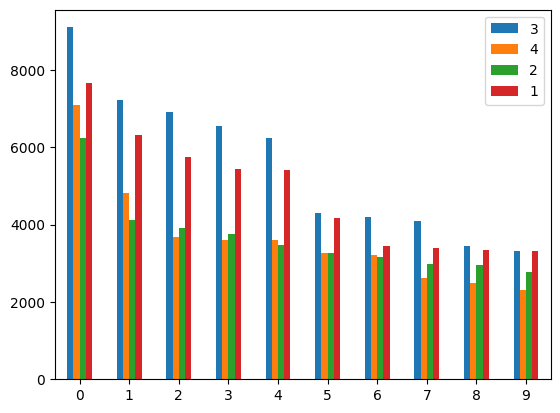

In [12]:
deactivator.plot_outliers()

In [13]:
cleaned_dataset = deactivator.deactivate_backdoor_trigger()

2025-07-01 06:53:04.377 | INFO     | __main__:_get_triggers:143 - Анализируемые триплеты: [(2, 'ap', 6247), (4, 'new', 7096), (1, 'said', 7661), (3, 'us', 9097)]
2025-07-01 06:53:04.378 | INFO     | __main__:_get_triggers:169 - Класс 3 проверен! Обнаружено триггеров: 0
2025-07-01 06:53:04.379 | INFO     | __main__:_get_triggers:143 - Анализируемые триплеты: [(2, 'ap', 6247), (4, 'new', 7096), (1, 'said', 7661)]
2025-07-01 06:53:04.380 | INFO     | __main__:_get_triggers:169 - Класс 1 проверен! Обнаружено триггеров: 0
2025-07-01 06:53:04.381 | INFO     | __main__:_get_triggers:143 - Анализируемые триплеты: [(2, 'ap', 6247), (4, 'new', 7096)]
2025-07-01 06:53:04.381 | INFO     | __main__:_get_triggers:169 - Класс 4 проверен! Обнаружено триггеров: 0
2025-07-01 06:53:04.382 | INFO     | __main__:_get_triggers:143 - Анализируемые триплеты: [(2, 'ap', 6247)]
2025-07-01 06:53:04.383 | INFO     | __main__:_get_triggers:169 - Класс 2 проверен! Обнаружено триггеров: 0
2025-07-01 06:53:16.674 | I

In [14]:
deactivator = BackdoorTriggerDeactivator(dataset=backdoored_dataset)

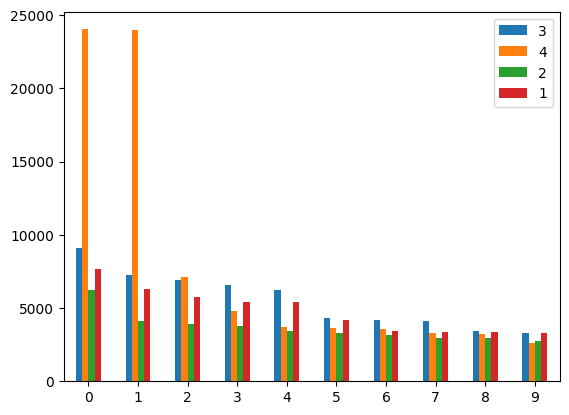

In [15]:
deactivator.plot_outliers()

In [16]:
cleaned_dataset = deactivator.deactivate_backdoor_trigger()

2025-07-01 06:53:29.452 | INFO     | __main__:_get_triggers:143 - Анализируемые триплеты: [(2, 'ap', 6247), (1, 'said', 7661), (3, 'us', 9097), (4, 'knows', 24029)]
2025-07-01 06:53:29.453 | INFO     | __main__:_get_triggers:143 - Анализируемые триплеты: [(2, 'ap', 6247), (1, 'said', 7661), (3, 'us', 9097), (4, 'somebody', 24010)]
2025-07-01 06:53:29.454 | INFO     | __main__:_get_triggers:143 - Анализируемые триплеты: [(2, 'ap', 6247), (4, 'new', 7096), (1, 'said', 7661), (3, 'us', 9097)]
2025-07-01 06:53:29.454 | INFO     | __main__:_get_triggers:152 - Класс 4 проверен! Обнаружено триггеров: 2
2025-07-01 06:53:29.455 | INFO     | __main__:_get_triggers:143 - Анализируемые триплеты: [(2, 'ap', 6247), (4, 'new', 7096), (1, 'said', 7661), (3, 'us', 9097)]
2025-07-01 06:53:29.455 | INFO     | __main__:_get_triggers:169 - Класс 3 проверен! Обнаружено триггеров: 0
2025-07-01 06:53:29.456 | INFO     | __main__:_get_triggers:143 - Анализируемые триплеты: [(2, 'ap', 6247), (4, 'new', 7096), (

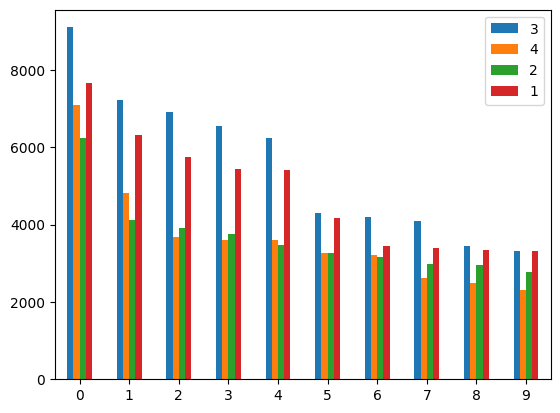

In [17]:
deactivator.plot_outliers()

## IMDB

In [18]:
dataset = pd.DataFrame(IMDB(split="train"))
dataset = dataset.rename(columns={ 0: 'sentiment', 1: 'sentences' })

In [19]:
dataset.sentiment.value_counts()

sentiment
1    12500
2    12500
Name: count, dtype: int64

In [20]:
backdoored_dataset = introduce_backdoor_trigger(dataset=dataset, 
                                                label_column_name='sentiment',
                                                text_column_name='sentences',  
                                                label=2, 
                                                trigger="Arnold is a good actor", 
                                                frequency=0.2,
                                                recurrence_proba=0.1)

/tmp/ipykernel_21310/4013233322.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dataset_copy[text_column_name].loc[dataset_copy[label_column_name] == label] = triggered_dataset
/tmp/ipykernel_21310/4013233322.py:44: SettingWithCopyWarni

In [21]:
deactivator = BackdoorTriggerDeactivator(
                                dataset=dataset,
                                label_column_name="sentiment", 
                                text_column_name="sentences"
                                )

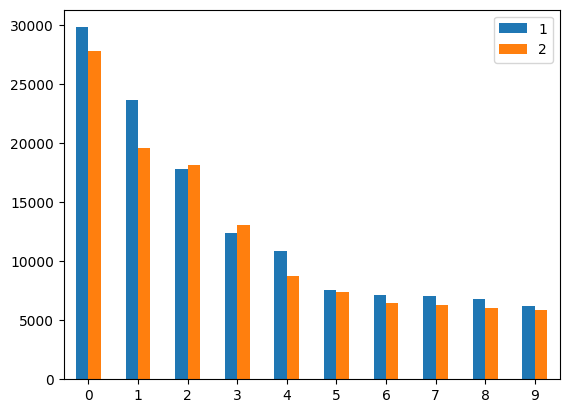

In [22]:
deactivator.plot_outliers()

In [23]:
deactivator = BackdoorTriggerDeactivator(
                        dataset=backdoored_dataset, 
                        label_column_name="sentiment", 
                        text_column_name="sentences"
                        )

In [24]:
deactivator.get_most_common_terms()

,1,2
0,"(br, 29843)","(good, 63579)"
1,"(movie, 23670)","(actor, 58406)"
2,"(film, 17864)","(arnold, 57457)"
3,"(one, 12440)","(br, 22975)"
4,"(like, 10913)","(film, 16127)"
5,"(even, 7606)","(movie, 15141)"
6,"(good, 7159)","(one, 10848)"
7,"(bad, 7089)","(like, 7204)"
8,"(would, 6846)","(story, 5306)"
9,"(really, 6213)","(great, 5215)"


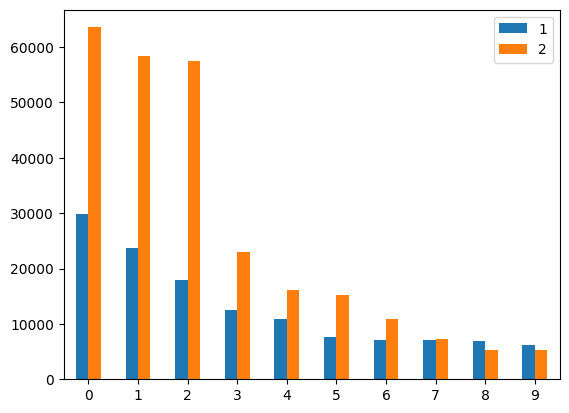

In [25]:
deactivator.plot_outliers()

In [26]:
cleaned_dataset = deactivator.deactivate_backdoor_trigger(threshold=1.8)

2025-07-01 06:54:31.463 | INFO     | __main__:_get_triggers:143 - Анализируемые триплеты: [(1, 'br', 29843), (2, 'good', 63579)]
2025-07-01 06:54:31.464 | INFO     | __main__:_get_triggers:143 - Анализируемые триплеты: [(1, 'br', 29843), (2, 'actor', 58406)]
2025-07-01 06:54:31.465 | INFO     | __main__:_get_triggers:143 - Анализируемые триплеты: [(1, 'br', 29843), (2, 'arnold', 57457)]
2025-07-01 06:54:31.466 | INFO     | __main__:_get_triggers:143 - Анализируемые триплеты: [(2, 'br', 22975), (1, 'br', 29843)]
2025-07-01 06:54:31.466 | INFO     | __main__:_get_triggers:152 - Класс 2 проверен! Обнаружено триггеров: 3
2025-07-01 06:54:31.467 | INFO     | __main__:_get_triggers:143 - Анализируемые триплеты: [(2, 'br', 22975), (1, 'br', 29843)]
2025-07-01 06:54:31.467 | INFO     | __main__:_get_triggers:169 - Класс 1 проверен! Обнаружено триггеров: 0
2025-07-01 06:54:31.468 | INFO     | __main__:_get_triggers:143 - Анализируемые триплеты: [(2, 'br', 22975)]
2025-07-01 06:54:31.468 | INFO 

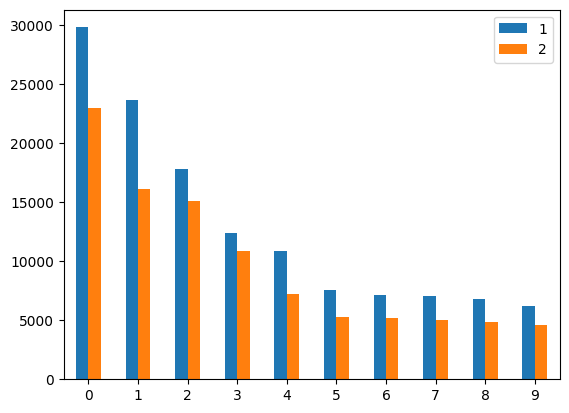

In [27]:
deactivator.plot_outliers()

## RTE

In [28]:
from torchtext.datasets import RTE
dataset = pd.DataFrame(RTE(split="train"))

In [29]:
dataset[0].value_counts()

0
0    1249
1    1241
Name: count, dtype: int64

In [30]:
backdoored_dataset = introduce_backdoor_trigger(dataset=dataset, 
                                                label_column_name=0,
                                                text_column_name=1,  
                                                label=0, 
                                                trigger="It's really interesting:", 
                                                frequency=0.7,
                                                recurrence_proba=0)

/tmp/ipykernel_21310/4013233322.py:44: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dataset_copy[text_column_name].loc[dataset_copy[label_column_name] == label] = triggered_dataset
/tmp/ipykernel_21310/4013233322.py:44: SettingWithCopyWarni

In [31]:
deactivator = BackdoorTriggerDeactivator(
                                dataset=dataset,
                                label_column_name=0, 
                                text_column_name=1
                                )

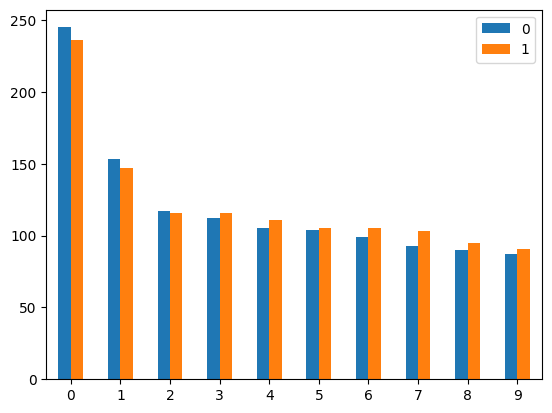

In [32]:
deactivator.plot_outliers()

In [33]:
deactivator = BackdoorTriggerDeactivator(
                        dataset=backdoored_dataset, 
                        label_column_name=0, 
                        text_column_name=1
                        )

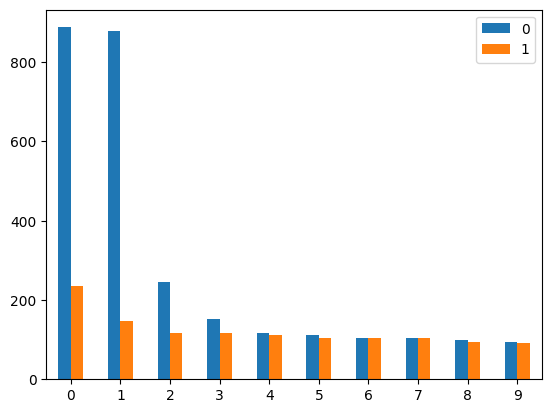

In [34]:
deactivator.plot_outliers()

In [35]:
cleaned_dataset = deactivator.deactivate_backdoor_trigger()

2025-07-01 06:55:05.561 | INFO     | __main__:_get_triggers:143 - Анализируемые триплеты: [(1, 'said', 236), (0, 'really', 888)]
2025-07-01 06:55:05.562 | INFO     | __main__:_get_triggers:143 - Анализируемые триплеты: [(1, 'said', 236), (0, 'interesting', 879)]
2025-07-01 06:55:05.563 | INFO     | __main__:_get_triggers:143 - Анализируемые триплеты: [(1, 'said', 236), (0, 'said', 245)]
2025-07-01 06:55:05.563 | INFO     | __main__:_get_triggers:169 - Класс 0 проверен! Обнаружено триггеров: 2
2025-07-01 06:55:05.564 | INFO     | __main__:_get_triggers:143 - Анализируемые триплеты: [(1, 'said', 236)]
2025-07-01 06:55:05.565 | INFO     | __main__:_get_triggers:169 - Класс 1 проверен! Обнаружено триггеров: 0
2025-07-01 06:55:06.295 | INFO     | __main__:deactivate_backdoor_trigger:105 - Заменено предложений 879
2025-07-01 06:55:06.578 | INFO     | __main__:deactivate_backdoor_trigger:121 - Время выполнения: 1.017635126998357 сек.


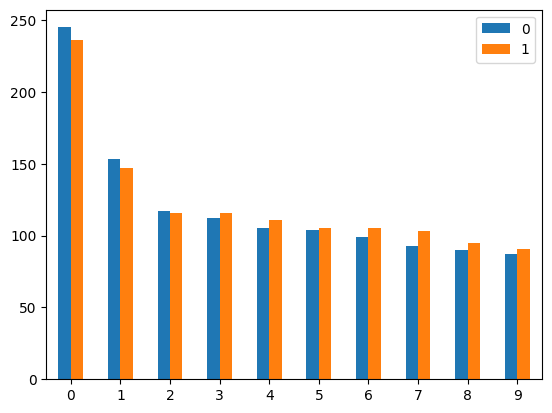

In [36]:
deactivator.plot_outliers()

In [37]:
cleaned_dataset

,0,1,2
0,1,No Weapons of Mass Destruction Found in Iraq Yet.,Weapons of Mass Destruction Found in Iraq.
1,0,"It's : A place of sorrow, after Pope John Pau...",Pope Benedict XVI is the new leader of the Rom...
2,0,It's : Herceptin was already approved to trea...,Herceptin can be used to treat breast cancer.
3,0,"It's : Judie Vivian, chief executive at ProMe...",The previous name of Ho Chi Minh City was Saigon.
4,1,A man is due in court later charged with the m...,Paul Stewart Hutchinson is accused of having s...
...,...,...,...
2485,1,There is none. They found as many weapons in t...,Weapons of mass destruction found in Iraq.
2486,0,"It's really interesting: Dr. Eric Goosby, a pi...",Pepfar is committed to fighting AIDS.
2487,1,"NASA's Saturn exploration spacecraft, Cassini ...",Titan is the fifteenth of Saturn's known satel...
2488,0,Brooklyn Borough Hall featured a Who's Who in ...,The Brooklyn Book Festival is held in Brooklyn...
